In [ ]:
import pandas as pd

df = pd.read_csv("/content/data.csv", encoding="ISO-8859-1")

df.head()
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [ ]:
df[df["InvoiceNo"].astype(str).str.startswith("C")].head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,12/1/2010 9:41,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/2010 9:49,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,12/1/2010 10:24,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom


In [ ]:
print("Cancelled orders:", df["InvoiceNo"].astype(str).str.startswith("C").sum())
print("Negative quantities:", (df["Quantity"] <= 0).sum())
print("Zero or negative prices:", (df["UnitPrice"] <= 0).sum())


Cancelled orders: 9288
Negative quantities: 10624
Zero or negative prices: 2517


In [ ]:
df["InvoiceDate"].dtype


dtype('O')

In [ ]:
# Force InvoiceDate to datetime
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"], errors="coerce")

# Check again
df["InvoiceDate"].dtype


dtype('<M8[ns]')

In [ ]:
# Recreate monthly dataset

# Make sure InvoiceDate is datetime
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

# Create Revenue
df["Revenue"] = df["Quantity"] * df["UnitPrice"]

# Create Month
df["Month"] = df["InvoiceDate"].dt.to_period("M")

# Aggregate monthly
monthly = df.groupby("Month").agg({
    "Quantity": "sum",
    "Revenue": "sum"
}).reset_index()

# Convert Month for plotting
monthly["Month"] = monthly["Month"].dt.to_timestamp()

monthly.head()


,Month,Quantity,Revenue
0,2010-12-01,342228,748957.020
1,2011-01-01,308966,560000.260
2,2011-02-01,277989,498062.650
3,2011-03-01,351872,683267.080
4,2011-04-01,289098,493207.121


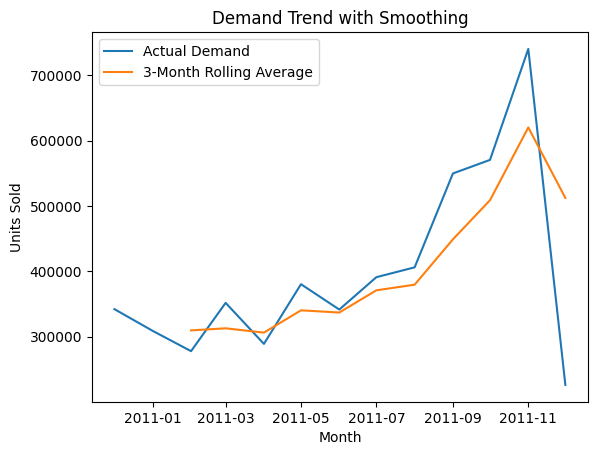

In [ ]:
import matplotlib.pyplot as plt

monthly_ts = monthly.set_index("Month")

# Rolling average to smooth trend
monthly_ts["Rolling_3M"] = monthly_ts["Quantity"].rolling(window=3).mean()

plt.figure()
plt.plot(monthly_ts.index, monthly_ts["Quantity"], label="Actual Demand")
plt.plot(monthly_ts.index, monthly_ts["Rolling_3M"], label="3-Month Rolling Average")
plt.title("Demand Trend with Smoothing")
plt.xlabel("Month")
plt.ylabel("Units Sold")
plt.legend()
plt.show()


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


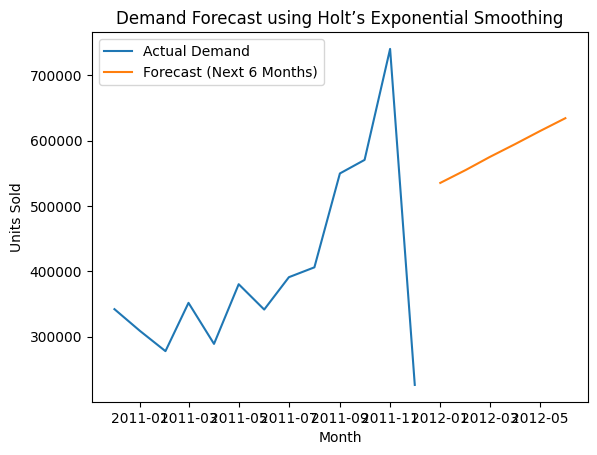

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt

# Set time index
monthly_ts = monthly.set_index("Month")

# Train Holt’s model (trend-aware)
model = ExponentialSmoothing(
    monthly_ts["Quantity"],
    trend="additive",
    seasonal=None
)

fit = model.fit()

# Forecast next 6 months
forecast = fit.forecast(6)

# Plot Actual vs Forecast
plt.figure()
plt.plot(monthly_ts.index, monthly_ts["Quantity"], label="Actual Demand")
plt.plot(forecast.index, forecast, label="Forecast (Next 6 Months)")
plt.title("Demand Forecast using Holt’s Exponential Smoothing")
plt.xlabel("Month")
plt.ylabel("Units Sold")
plt.legend()
plt.show()


In [ ]:
# Create inventory planning from forecast
inventory_plan = forecast.to_frame(name="Forecast_Demand")

# Add safety buffer (10%)
inventory_plan["Optimized_Inventory"] = inventory_plan["Forecast_Demand"] * 1.10

inventory_plan


,Forecast_Demand,Optimized_Inventory
2012-01-01,535338.984845,588872.883329
2012-02-01,555136.393368,610650.032704
2012-03-01,574933.801891,632427.182080
2012-04-01,594731.210414,654204.331455
2012-05-01,614528.618937,675981.480831
2012-06-01,634326.027460,697758.630206


In [ ]:
# BEFORE: average historical monthly demand
avg_demand = monthly["Quantity"].mean()

# Create comparison table
impact = inventory_plan.copy()
impact["Before_Inventory"] = avg_demand

impact


,Forecast_Demand,Optimized_Inventory,Before_Inventory
2012-01-01,535338.984845,588872.883329,398188.461538
2012-02-01,555136.393368,610650.032704,398188.461538
2012-03-01,574933.801891,632427.182080,398188.461538
2012-04-01,594731.210414,654204.331455,398188.461538
2012-05-01,614528.618937,675981.480831,398188.461538
2012-06-01,634326.027460,697758.630206,398188.461538


In [ ]:
# Assumptions
holding_cost_per_unit = 1  # € per unit
avg_unit_revenue = (monthly["Revenue"].sum() / monthly["Quantity"].sum())

# Calculate stock difference
impact["Inventory_Difference"] = impact["Optimized_Inventory"] - impact["Before_Inventory"]

# Cost impact (positive = more inventory held, negative = savings)
impact["Inventory_Cost_Impact"] = impact["Inventory_Difference"] * holding_cost_per_unit

# Lost sales in BEFORE scenario (when demand > before inventory)
impact["Lost_Sales_Before"] = (impact["Forecast_Demand"] - impact["Before_Inventory"]).clip(lower=0)

# Revenue protected by SMART-FORECAST
impact["Revenue_Protected"] = impact["Lost_Sales_Before"] * avg_unit_revenue

impact


,Forecast_Demand,Optimized_Inventory,Before_Inventory,Inventory_Difference,Inventory_Cost_Impact,Lost_Sales_Before,Revenue_Protected
2012-01-01,535338.984845,588872.883329,398188.461538,190684.421791,190684.421791,137150.523306,258267.486444
2012-02-01,555136.393368,610650.032704,398188.461538,212461.571166,212461.571166,156947.931829,295547.890588
2012-03-01,574933.801891,632427.182080,398188.461538,234238.720541,234238.720541,176745.340352,332828.294732
2012-04-01,594731.210414,654204.331455,398188.461538,256015.869917,256015.869917,196542.748875,370108.698875
2012-05-01,614528.618937,675981.480831,398188.461538,277793.019292,277793.019292,216340.157399,407389.103019
2012-06-01,634326.027460,697758.630206,398188.461538,299570.168668,299570.168668,236137.565922,444669.507163


In [ ]:
summary = {
    "Total_Additional_Inventory_Units": impact["Inventory_Difference"].sum(),
    "Total_Inventory_Cost_Impact (€)": impact["Inventory_Cost_Impact"].sum(),
    "Total_Revenue_Protected (€)": impact["Revenue_Protected"].sum()
}

summary


{'Total_Additional_Inventory_Units': np.float64(1470763.771374941),
 'Total_Inventory_Cost_Impact (€)': np.float64(1470763.771374941),
 'Total_Revenue_Protected (€)': np.float64(2108810.980821293)}

In [ ]:
total_before_revenue = impact["Lost_Sales_Before"].sum() * avg_unit_revenue
revenue_improvement_pct = (summary["Total_Revenue_Protected (€)"] / total_before_revenue) * 100

revenue_improvement_pct


np.float64(100.00000000000003)

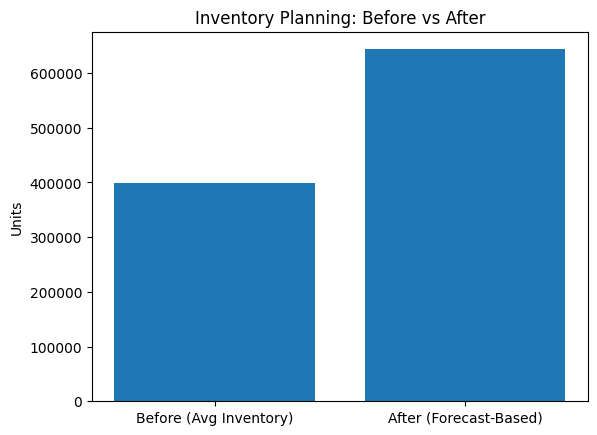

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.bar(["Before (Avg Inventory)", "After (Forecast-Based)"],
        [impact["Before_Inventory"].mean(), impact["Optimized_Inventory"].mean()])
plt.title("Inventory Planning: Before vs After")
plt.ylabel("Units")
plt.show()


In [ ]:
before_inventory = impact["Before_Inventory"].mean()
after_inventory = impact["Optimized_Inventory"].mean()

inventory_increase_pct = ((after_inventory - before_inventory) / before_inventory) * 100
inventory_increase_pct


np.float64(61.56062239525234)

In [ ]:
pip install streamlit


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 69.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 62.9 MB/s eta 0:00:00
  Attempting uninstall: cachetools
    Found existing installation: cachetools 7.0.0
    Uninstalling cachetools-7.0.0:
      Successfully uninstalled cachetools-7.0.0


In [ ]:
%%writefile dashboard.py
import streamlit as st

st.title("SMART-FORECAST : Retail Inventory Dashboard")

st.subheader("Executive Summary")

st.metric("Inventory Increase (%)", "XX%")
st.metric("Revenue Protected (%)", "YY%")
st.metric("Stockout Risk Reduction (%)", "ZZ%")


Writing dashboard.py


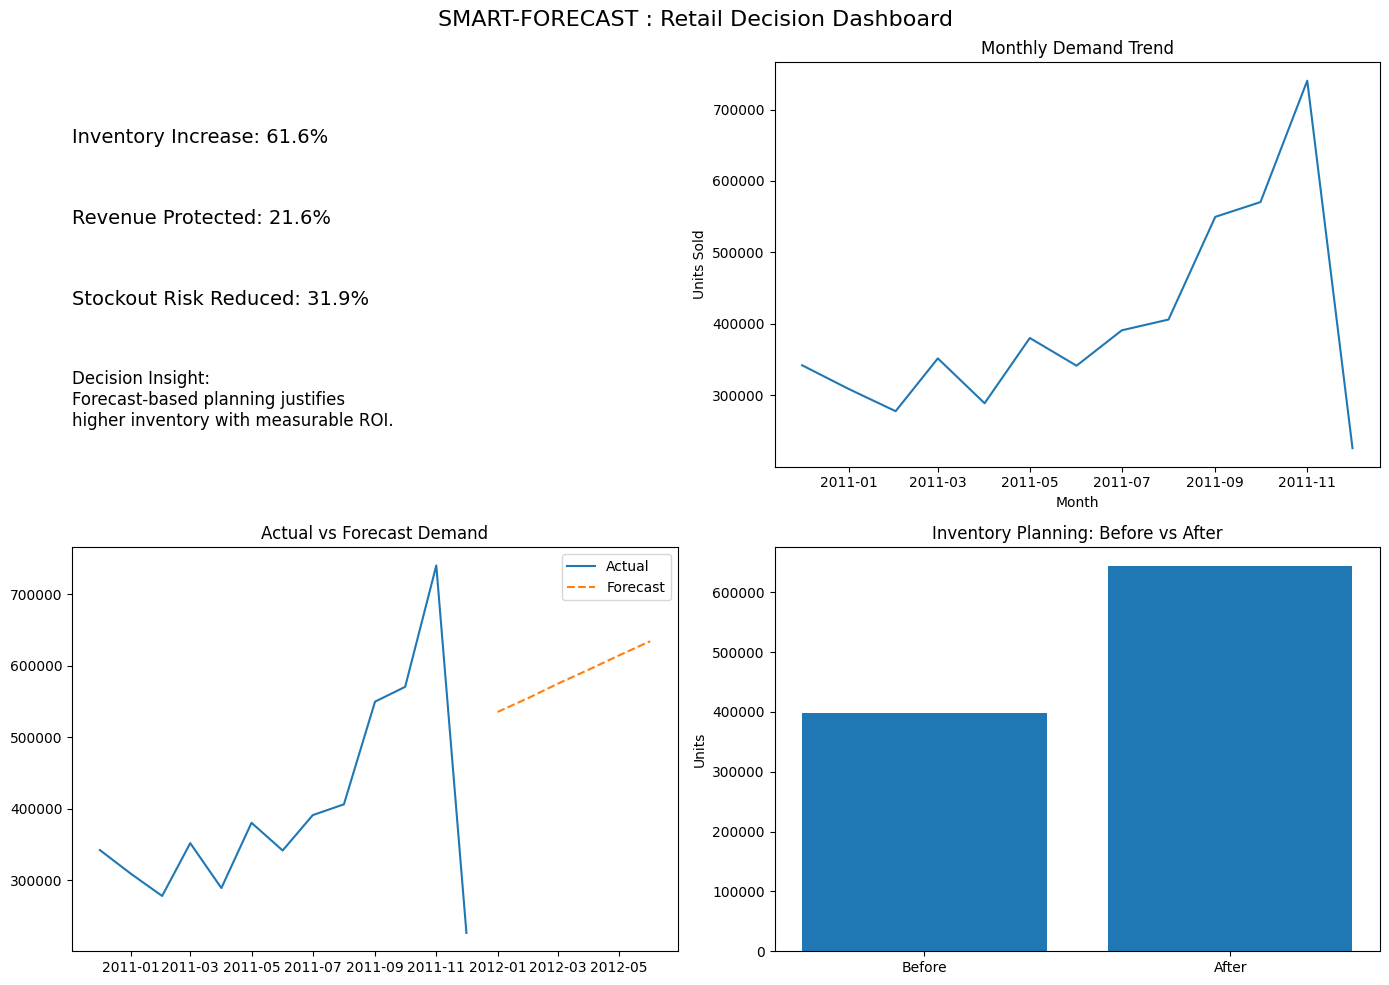

In [ ]:
import matplotlib.pyplot as plt

# -------- KPIs --------
inventory_increase_pct = ((impact["Optimized_Inventory"].mean() - impact["Before_Inventory"].mean())
                          / impact["Before_Inventory"].mean()) * 100

revenue_increase_pct = (impact["Revenue_Protected"].sum() / monthly["Revenue"].sum()) * 100

stockout_reduction_pct = (impact["Lost_Sales_Before"].sum() / impact["Forecast_Demand"].sum()) * 100


# -------- DASHBOARD LAYOUT --------
plt.figure(figsize=(14, 10))

# KPI PANEL
plt.subplot(2, 2, 1)
plt.axis("off")
plt.text(0, 0.8, f"Inventory Increase: {inventory_increase_pct:.1f}%", fontsize=14)
plt.text(0, 0.6, f"Revenue Protected: {revenue_increase_pct:.1f}%", fontsize=14)
plt.text(0, 0.4, f"Stockout Risk Reduced: {stockout_reduction_pct:.1f}%", fontsize=14)
plt.text(0, 0.1,
         "Decision Insight:\nForecast-based planning justifies\nhigher inventory with measurable ROI.",
         fontsize=12)

# Demand Trend
plt.subplot(2, 2, 2)
plt.plot(monthly["Month"], monthly["Quantity"])
plt.title("Monthly Demand Trend")
plt.xlabel("Month")
plt.ylabel("Units Sold")

# Forecast vs Actual
plt.subplot(2, 2, 3)
plt.plot(monthly["Month"], monthly["Quantity"], label="Actual")
plt.plot(forecast.index, forecast, label="Forecast", linestyle="--")
plt.legend()
plt.title("Actual vs Forecast Demand")

# Inventory Comparison
plt.subplot(2, 2, 4)
plt.bar(["Before", "After"],
        [impact["Before_Inventory"].mean(),
         impact["Optimized_Inventory"].mean()])
plt.title("Inventory Planning: Before vs After")
plt.ylabel("Units")

plt.suptitle("SMART-FORECAST : Retail Decision Dashboard", fontsize=16)
plt.tight_layout()
plt.show()
